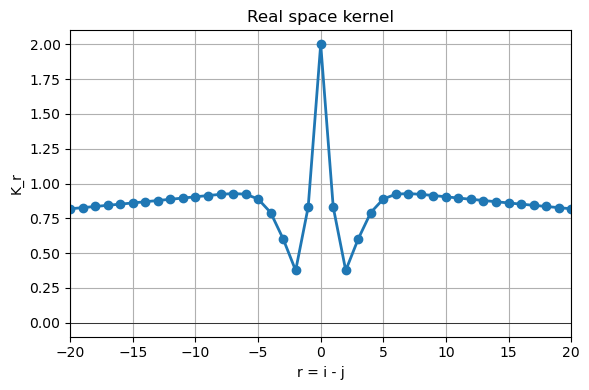

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from ewaldnn1d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "rough" # "smooth" or "rough"

N_grid = 512 # number of grid points
if data_regime == "smooth":
    M_cutoff = 50 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.2 * m)**2 # std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid - 1 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 10000
lr = 1e-2 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # padding mode for convolution-based routines: either "zero" or "reflect"
N_feat = 1 # number of local features per grid point

# interaction kernel parameters
kernel_regime = "custom"  # "power", "yukawa", or "exp", or "custom"

lam = 10.0
alpha = 1.0
xi = 100.0
amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy

if kernel_regime == "power":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="power", alpha=alpha)
elif kernel_regime == "yukawa": 
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="yukawa", lam=lam)
elif kernel_regime == "exp":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="exp", xi=xi)
elif kernel_regime == "custom":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_dct(rho, kernel="exp", xi=xi) + \
                amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode=pad_mode) + \
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode=pad_mode)
    
R = 20 
r_grid = torch.arange(-R, R+1)
plt.figure(figsize=(6,4))
if kernel_regime == "yukawa":
    plt.plot(r_grid, K_yukawa(r_grid, lam=lam), 'o-', linewidth=2) 
elif kernel_regime == "power":
    plt.plot(r_grid, K_power(r_grid, alpha=alpha), 'o-', linewidth=2) 
elif kernel_regime == "exp":
    plt.plot(r_grid, K_exp(r_grid, xi=xi), 'o-', linewidth=2)
elif kernel_regime == "custom":
    K_r = K_exp(r_grid, xi=xi) + \
          amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + \
          amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2)
    plt.plot(r_grid, K_r, 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
# plt.ylim((0.0, 1.0))
plt.title(f"Real space kernel")
plt.grid(True)
plt.tight_layout()
plt.show()


# generate train/test split
rho_train, d_rho_train, a_train = sample_density_batch(N_train, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)    # (N_val, N_grid)
features_train = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)



# N_batch = 50
# rho_batch, _, a_batch = sample_density_batch(N_batch, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)
# np.savetxt("Figure_2/rho_batch_" + data_regime + ".txt", rho_batch.cpu().numpy())
# np.savetxt("Figure_2/a_batch_" + data_regime + ".txt", a_batch.cpu().numpy())
# data = np.column_stack([m.cpu().numpy(), std_harm.cpu().numpy()])
# np.savetxt(f"Figure_2/harmonics_stats_" + data_regime + ".txt", data)

Training

In [2]:
ckpt_dir = "LearningNonLocalKernel_wRSDCTKernel_checkpoints"
flag_train = True  # set to True to train models
learning_regime = "hybrid"  # "dct_rs_blind", "dct_exp_rs_mixture", "dct_ms_blind", or "hybrid"
R = 10  # for hybrid
n_exp_components = 1  # for hybrid

if data_regime == "smooth":
    range_ms = M_cutoff  # for dct_ms_blind
else:
    range_ms = N_grid - 1  # for dct_ms_blind

if kernel_regime == "exp":
            run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_xi{xi}" + learning_regime
elif kernel_regime == "yukawa":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_lam{lam}" + learning_regime
elif kernel_regime == "power":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}" + learning_regime
elif kernel_regime == "custom":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + '_' + learning_regime

if flag_train:

    torch.manual_seed(1234) # for reproducibility
    
    if learning_regime == "dct_exp_rs_mixture":
        model = DCTKernelEnergyNN(
            N=N_grid,
            learning_mode="dct_exp_rs_mixture",
            n_components=1,
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)
    elif learning_regime == "dct_rs_blind":
        model = DCTKernelEnergyNN(
            N=N_grid,
            learning_mode="dct_rs_blind",
            zero_r_flag=False,   # or True if you want K_0=0
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)
    elif learning_regime == "dct_ms_blind":
        model = DCTKernelEnergyNN(
            N=N_grid,
            learning_mode="dct_ms_blind",
            range_ms=range_ms,
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)
    elif learning_regime == "hybrid":
        model = HybridKernelEnergyNN(
            N=N_grid,
            R=R,
            n_exp_components=n_exp_components,
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)
    else:
        raise ValueError(f"Unknown learning_regime: {learning_regime}")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Reduce LR when val loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
    )

    hist, best_epoch = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        max_epochs=N_epochs,
        patience=patience,
        min_delta=min_delta,
        ckpt_dir=ckpt_dir,
        run_name=run_name,
        learning_regime=learning_regime,
        N_grid=N_grid,
        device=device,
    )


[0001] train=10.403037 | val=6.497444 | best_val=6.497444 (epoch 1)
[0010] train=0.268033 | val=0.213421 | best_val=0.213421 (epoch 10)
[0020] train=0.204783 | val=0.159166 | best_val=0.159166 (epoch 20)
[0030] train=0.157221 | val=0.118663 | best_val=0.118663 (epoch 30)
[0040] train=0.125488 | val=0.092985 | best_val=0.092985 (epoch 40)
[0050] train=0.107001 | val=0.078918 | best_val=0.078918 (epoch 50)
[0060] train=0.095691 | val=0.070552 | best_val=0.070552 (epoch 60)
[0070] train=0.087098 | val=0.063975 | best_val=0.063975 (epoch 70)
[0080] train=0.079415 | val=0.058293 | best_val=0.058293 (epoch 80)
[0090] train=0.071775 | val=0.052368 | best_val=0.052368 (epoch 90)
[0100] train=0.064721 | val=0.047040 | best_val=0.047040 (epoch 100)
[0110] train=0.057947 | val=0.042027 | best_val=0.042027 (epoch 110)
[0120] train=0.051649 | val=0.037465 | best_val=0.037465 (epoch 120)
[0130] train=0.046196 | val=0.033459 | best_val=0.033459 (epoch 130)
[0140] train=0.041449 | val=0.029454 | best_

   epoch  train_loss  val_loss
0      1   10.403037  6.497444
1      2    4.732340  2.641842
2      3    1.904801  1.000666
3      4    0.795674  0.438648
4      5    0.431605  0.292123


<Axes: title={'center': 'rs_dct_kernel_rough_custom_hybrid'}, xlabel='epoch'>

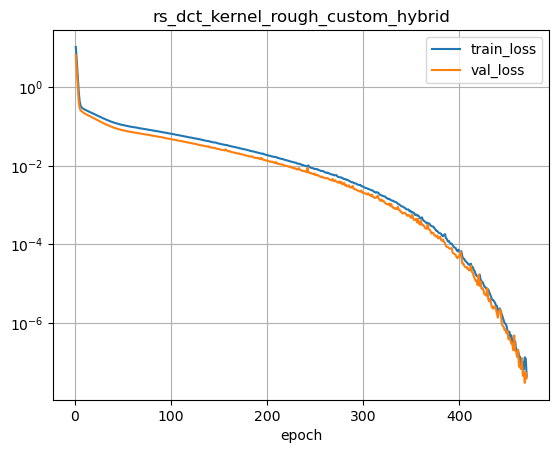

In [3]:
path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

Evaluate performance of training

Learned Hybrid Kernel parameters:
Local kernel range R: 10
Nonlocal exponential mixture components: 1
Amplitudes A_n: [1.0009651]
Sigmas sigma_n: [99.65404]
Local kernel values K_r (r=0..R): [ 9.9861753e-01 -1.6028528e-01 -6.0673970e-01 -3.6955366e-01
 -1.7027530e-01 -6.2665045e-02 -1.9854857e-02 -5.2429214e-03
 -2.1080058e-03  2.6809107e-04 -6.6639495e-04]


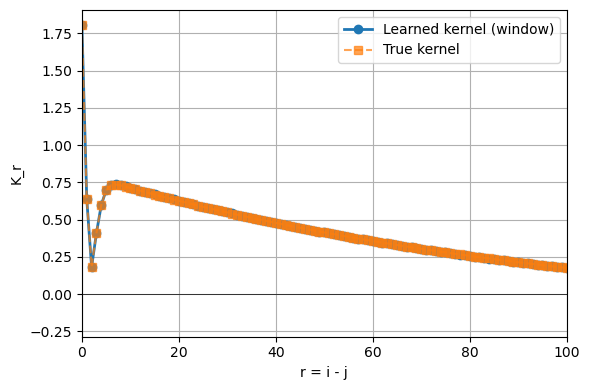

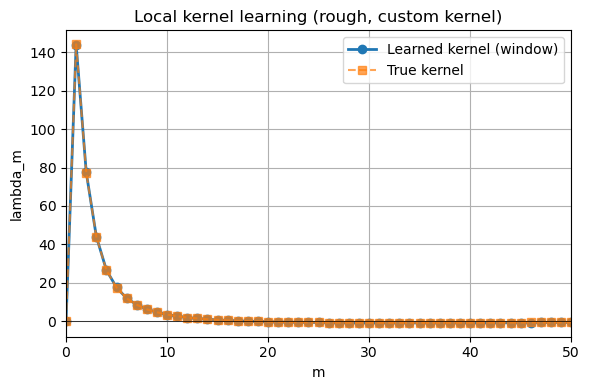

In [ ]:
if learning_regime == "hybrid":
    model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        HybridKernelEnergyNN,
        device=device
    )
else:
    model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        DCTKernelEnergyNN,
        device=device
    )

if learning_regime == "dct_exp_rs_mixture":
     print("Learned Exponential Mixture RS DCT Kernel parameters:")
     print(model.nonlocal_kernel.n_components)
     print("Amplitudes A_n:", model.nonlocal_kernel.amplitudes.detach().cpu().numpy())
     print("Sigmas sigma_n:", F.softplus(model.nonlocal_kernel.log_sigmas).detach().cpu().numpy())
     with torch.no_grad():
        k_full = model.nonlocal_kernel.build_kernel().detach().cpu().numpy()  # (N_grid,)
elif learning_regime == "dct_rs_blind":
    with torch.no_grad():
        k_full = model.nonlocal_kernel.rs_kernel.detach().cpu().numpy()  # (N_grid,)
elif learning_regime == "dct_ms_blind":
    print("Learned MS DCT Kernel parameters:")
    print("Range m:", model.nonlocal_kernel.range_ms)
    with torch.no_grad():
        lam_K = torch.zeros(N_grid, dtype=dtype)
        lam_K[0] = 0.0
        lam_K[1:1+range_ms] = model.nonlocal_kernel.ms_kernel.detach().cpu()
        k_full = kernel_from_eigenvals_dct(lam_K).cpu().numpy()
elif learning_regime == "hybrid":
    print("Learned Hybrid Kernel parameters:")
    print("Local kernel range R:", model.R)
    print("Nonlocal exponential mixture components:", model.n_exp_components)

    print("Amplitudes A_n:", model.nonlocal_kernel.amplitudes.detach().cpu().numpy())
    print("Sigmas sigma_n:", F.softplus(model.nonlocal_kernel.log_sigmas).detach().cpu().numpy())
    
    with torch.no_grad():
        k_local_small = model.local_kernel.build_kernel().squeeze()  # (2R+1,)
        k_nonlocal = model.nonlocal_kernel.build_kernel()            # (N_grid,)

        R = model.R  # local range
        print("Local kernel values K_r (r=0..R):", k_local_small[R:].cpu().numpy())

        # take r = 0..R from symmetric kernel and pad zeros up to N_grid
        # k_local_small layout: [-R, ..., -1, 0, 1, ..., R]
        # index R is r=0, R+1..2R is r=1..R
        k_local_full = torch.cat(
            [
                k_local_small[R:],  # (R+1,)  -> r=0..R
                torch.zeros(N_grid - 1 - R, device=device, dtype=dtype),
            ],
            dim=0,
        )  # (N_grid,)
        k_full = k_local_full.cpu().numpy() + k_nonlocal.cpu().numpy()  # (N_grid,)


r_grid = np.arange(0, N_grid)

if kernel_regime == "exp":
    def K_true(r):
        return np.exp(-np.abs(r) / xi)
elif kernel_regime == "yukawa":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / lam) / np.maximum(r_abs, 1.0)
        return out * (r_abs > 0)
elif kernel_regime == "power":
    def K_true(r):
        r_abs = np.abs(r)
        out = 1.0 / (np.maximum(r_abs, 1.0)**alpha)
        return out * (r_abs > 0)    
elif kernel_regime == "custom":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / xi) + \
              amp_Gaussian_1 * np.exp(- (r_abs**2) / (sigma_Gaussian_1**2)) + \
              amp_Gaussian_2 * np.exp(- (r_abs**2) / (sigma_Gaussian_2**2))
        return out 

k_true = K_true(r_grid)
lamb_K_true = kernel_eigenvals_dct(torch.tensor(k_true, dtype=dtype))
lamb_K_true[0] = 0.0  # enforce zero mode
k_true = kernel_from_eigenvals_dct(lamb_K_true).cpu().numpy()

lamb_K_full = kernel_eigenvals_dct(torch.tensor(k_full, dtype=dtype))
lamb_K_full[0] = 0.0  # enforce zero mode
k_full = kernel_from_eigenvals_dct(lamb_K_full).cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full , 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(0, 100)
# plt.ylim((-0.01, 0.01))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(r_grid, lamb_K_full , 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, lamb_K_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("m")
plt.ylabel("lambda_m")
plt.xlim(0, 50)
#plt.ylim((-0.05, 0.0))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
elif kernel_regime == "custom":
    plt.title(f"Local kernel learning ({data_regime}, custom kernel)")
plt.tight_layout()
plt.show()


# data = np.column_stack([r_grid, k_full, k_true])
# np.savetxt(f"Figure_2/nonlocal_rs_kernel_xi{xi}" + "_" + data_regime + ".txt", data)

# data = np.column_stack([r_grid, lamb_K_full, lamb_K_true])
# np.savetxt(f"Figure_2/nonlocal_ms_kernel_xi{xi}" + "_" + data_regime + ".txt", data)

# data = np.column_stack([r_grid, k_full, k_true])
# np.savetxt(f"Figure_2/hybrid_nonlocal_rs_kernel_custom_R{R}_xi{xi}.txt", data)
# data = np.column_stack([r_grid, lamb_K_full, lamb_K_true])
# np.savetxt(f"Figure_2/hybrid_nonlocal_ms_kernel_custom_R{R}_xi{xi}.txt", data)